In [1]:
type Node
    center::Array{Float64}
    cell_size::Float64
    level::Int
    parent::Int
    index::Int
    number_of_particles::Int
   
    position::Array{Float64}
    
    velocity::Array{Float64}
    
    children::Array{Int}
    
    siblings::Array{Int}    
    
    multipole_coeff
    local_coeff

     neighbours::Array{Int}
    
    
    function Node() 
        this = new()
        this.center= [0.5,0.5]        
        this.cell_size=1
        this.parent=0
        this.children=[]
        this.position=[]
        this.velocity=[]
        this.number_of_particles=0
        this.level=0
        this.local_coeff=zeros(1,9)*(1+im)
        this.neighbours=[]
        this.siblings=[]
        return this
    end
end

In [2]:
function split!(Parent,tree)   

Child1=Node()
Child2=Node()
Child3=Node()
Child4=Node()

n=size(tree,1)
    
    Parent.children=[n+1,n+2,n+3,n+4]

    Child1.index=n+1
    Child1.cell_size=0.5*Parent.cell_size;
    Child1.center=Parent.center+0.5*[-Child1.cell_size,-Child1.cell_size]
    Child1.parent=Parent.index
    Child1.number_of_particles=0
    Child1.level=Parent.level+1
    Child1.siblings=[n+2,n+3,n+4]

    Child2.index=n+2    
    Child2.cell_size=0.5*Parent.cell_size
    Child2.center=Parent.center+0.5*[Child2.cell_size,-Child2.cell_size]
    Child2.parent=Parent.index
    Child2.number_of_particles=0
    Child2.level=Parent.level+1
    Child2.siblings=[n+1,n+3,n+4]


    Child3.index=n+3    
    Child3.cell_size=0.5*Parent.cell_size
    Child3.center=Parent.center+0.5*[Child3.cell_size,Child3.cell_size]
    Child3.parent=Parent.index
    Child3.number_of_particles=0
    Child3.level=Parent.level+1
    Child3.siblings=[n+1,n+2,n+4]
    
    Child4.index=n+4
    Child4.cell_size=0.5*Parent.cell_size
    Child4.center=Parent.center+0.5*[-Child4.cell_size,Child4.cell_size]
    Child4.parent=Parent.index
    Child4.number_of_particles=0
    Child4.level=Parent.level+1
    Child4.siblings=[n+1,n+2,n+3]
    
  if Parent.number_of_particles!=0            
                
    
    relative_position=zeros(2,Parent.number_of_particles)
    relative_position[1,:]=Parent.position[1,:]-Parent.center[1]
    relative_position[2,:]=Parent.position[2,:]-Parent.center[2]
    

for n= 1:Parent.number_of_particles
           
    if relative_position[1,n]<0
                
        if  relative_position[2,n]<0
            Child1.position = [Child1.position; Parent.position[:,n] ]
                    Child1.velocity = [Child1.velocity; Parent.velocity[:,n] ]
                    
        else
            Child4.position = [Child4.position; Parent.position[:,n] ]
            Child4.velocity = [Child4.velocity; Parent.velocity[:,n] ]

        end
    end
    
    if  relative_position[1,n]>0
        
        if relative_position[2,n]<0
            Child2.position= [Child2.position; Parent.position[:,n]]
            Child2.velocity= [Child2.velocity; Parent.velocity[:,n]]

        else
            Child3.position =[Child3.position; Parent.position[:,n]]
            Child3.velocity =[Child3.velocity; Parent.velocity[:,n]]

        end
            
    end
                
end

 
Child1.number_of_particles= size(Child1.position,1)/2
Child2.number_of_particles= size(Child2.position,1)/2
Child3.number_of_particles= size(Child3.position,1)/2
Child4.number_of_particles= size(Child4.position,1)/2

Child1.position=reshape(Child1.position,2,Child1.number_of_particles)
Child2.position=reshape(Child2.position,2,Child2.number_of_particles)
Child3.position=reshape(Child3.position,2,Child3.number_of_particles)
Child4.position=reshape(Child4.position,2,Child4.number_of_particles)


        Child1.velocity=reshape(Child1.velocity,2,Child1.number_of_particles)
        Child2.velocity=reshape(Child2.velocity,2,Child2.number_of_particles)
        Child3.velocity=reshape(Child3.velocity,2,Child3.number_of_particles)
        Child4.velocity=reshape(Child4.velocity,2,Child4.number_of_particles)
            
        
end
    
    push!(tree,Child1)  
    push!(tree,Child2)  
    push!(tree,Child3)  
    push!(tree,Child4)  
    
end

split! (generic function with 1 method)

In [3]:
using PyPlot
function show_particles(Node,color)
    plot(Node.position[1,:],Node.position[2,:],color)
end
function show_boundary(Node)
    x=[Node.center[1]-0.5*Node.cell_size,Node.center[1]+0.5*Node.cell_size,Node.center[1]+0.5*Node.cell_size,Node.center[1]-0.5*Node.cell_size];
    y=[Node.center[2]-0.5*Node.cell_size,Node.center[2]-0.5*Node.cell_size,Node.center[2]+0.5*Node.cell_size,Node.center[2]+0.5*Node.cell_size];
    plot(x,y,"r-");
end

show_boundary (generic function with 1 method)

In [4]:
function isfar(Node,z)
    is=false
    if abs(real(z)-Node.center[1])>1.5*Node.cell_size || abs(imag(z)-Node.center[2])>1.5*Node.cell_size
       is=true
    end
    return is
end

isfar (generic function with 1 method)

In [5]:
function compute_far_potential(Node,z)
    p=8;
           
    phi=0+0im;
    if Node.number_of_particles!=0
        
        z_0= Node.center[1]+Node.center[2]*1im;
        phi=Node.number_of_particles*log(z-z_0);
           
    for i=1:p           
            phi=phi+Node.multipole_coeff[i]/(z-z_0).^i;
           end
           phi=real(phi)
    end
    
    return phi
end

compute_far_potential (generic function with 1 method)

In [6]:
function compute_near_potential(Node,z)
         phi=0
            if Node.number_of_particles!=0
                
                x=[real(z);imag(z)];
        
        for i=1:Node.number_of_particles
            distance=norm(x-Node.position[:,i]); 
                    if distance>10.0^-5    #not the same particle    
                    phi=phi+log(distance);
                    end
                end
            end
        
    return phi
end

compute_near_potential (generic function with 1 method)

In [7]:
function  compute_potential_BH(Node,tree,z,phi)
    if Node.number_of_particles ==0
        return phi
    end

if isfar(Node,z)
    phi=phi+compute_far_potential(Node,z)
        
elseif !isempty(Node.children)
    for i=1:4
                phi=compute_potential_BH( tree[Node.children[i]], tree, z,phi)
    end        
    else
       phi=phi+compute_near_potential(Node,z)
end
    
    return phi
end

compute_potential_BH (generic function with 1 method)

In [8]:
function compute_multipole_coeff(Node)
    p=8
    Node.multipole_coeff=zeros(1,p)*(1+1im)
    if Node.number_of_particles!=0
        for k=1:p
            for n=1:Node.number_of_particles
                Node.multipole_coeff[k]=Node.multipole_coeff[k]+ (-1/k)*( (Node.position[1,n]-Node.center[1]) + (Node.position[2,n]-Node.center[2])*1im)^k;
            end
        end
    end    
end     

compute_multipole_coeff (generic function with 1 method)

In [9]:
function M2M(Node1, tree)            

p=8;     
            power=collect(1:1:p)
            shift=1im.^power
            power=power'
            z_0=0.25 *Node1.cell_size*(-1-1im)
            z_power=z_0.^power          

    M2Mmatrix= zeros(p,p)*(1+1im)
            for l=1:p
                for k=1:l
            M2Mmatrix[l,k]=1/z_power[k]*binomial(l-1,k-1)
                end
            end             
            
    zero_term=(-tree[Node1.children[1]].number_of_particles)./power'
    b=z_power.'.*(zero_term+M2Mmatrix*(tree[Node1.children[1]].multipole_coeff).')
                 Node1.multipole_coeff=b.'           

            
            for i=2:4
                   M2Mmatrix=M2Mmatrix*diagm(conj(shift));
    
                   z_power=z_power.*shift.'             
                
        zero_term=(-tree[Node1.children[i]].number_of_particles)./power'
        b=z_power.'.*(zero_term+M2Mmatrix*(tree[Node1.children[i]].multipole_coeff).')
                
                Node1.multipole_coeff=Node1.multipole_coeff+b.'
      
end   
    
end

M2M (generic function with 1 method)

In [10]:
function M2L(Node1,Node2)
           #first Node1 -> Node2  M2L
    if Node1.number_of_particles==0 || Node2.number_of_particles==0
        return
    end
    
    p=8;
    
    z_0=(Node1.center[1]+ 1im*Node1.center[2]-Node2.center[1]-1im*Node2.center[2])
            power=collect(0:1:p)'
            inv_z=(1/z_0).^power;  #from z^0 to z^p
            shift=(-1).^power
    M2LMatrix=zeros(p+1,p+1)*(1+1im)
            
            M2LMatrix[1,1]=log(-z_0)
            M2LMatrix[1,2:end]=inv_z[2:end].*shift[2:end];          
            
            for l=2:p+1
            M2LMatrix[l,1] =-inv_z[l]/(l-1)
                for k=2:p+1
            M2LMatrix[l,k] =inv_z[l]*inv_z[k]*binomial(l+k-3,k-2)*(-1)^(k-1)
                end
            end
            
            a=[Node1.number_of_particles; Node1.multipole_coeff.']
            Node2.local_coeff=Node2.local_coeff+ (M2LMatrix*a).'
end         

M2L (generic function with 1 method)

In [11]:
function L2L(Node,tree)
    p=8
    
    if Node.number_of_particles ==0 || isempty(Node.children)
            return
    end
        
        z_0=0.25*Node.cell_size*(1+1im);  #for children(1);
    power=collect(0:1:p)'
        z_power=(-z_0).^power
        
    L2LMatrix=zeros(p+1,p+1)*(1+im)
        
        for m=1:p+1
        for k=m:p+1
            L2LMatrix[m,k]=z_power[k]/z_power[m]*binomial(k-1,m-1)
            end
        end
           
    tree[Node.children[1]].local_coeff=tree[Node.children[1]].local_coeff+Node.local_coeff*L2LMatrix.'
    
     power=collect(0:1:p)
        shift1=(1im).^power
        shift2=(-1im).^power
        shift_M1=diagm(shift1)
        shift_M2=diagm(shift2)
        
        for i=2:4
            L2LMatrix=shift_M2*L2LMatrix*shift_M1
        tree[Node.children[i]].local_coeff=tree[Node.children[i]].local_coeff+Node.local_coeff*L2LMatrix.'
        end
end

L2L (generic function with 1 method)

In [12]:
function isNodefar(Node1,Node2)
        is=false
        if Node1.cell_size != Node2.cell_size
            error("not in the same level")
        end  
    if norm([Node1.center[1],Node1.center[2]]-[Node2.center[1],Node2.center[2]]) >=  2*Node1.cell_size
                is=true
        end
    return is
end

isNodefar (generic function with 1 method)

In [13]:
function balance_split!(Node,tree,l,leaf)
    # construct a balanced tree of level l   return the indexes of the leaf nodes
     #   compute_multipole_coeff(Node)   #for BH
    
    if l !=0  
        split!(Node,tree)
        
        for i=1:4
            child=tree[Node.children[i]]
            balance_split!(child,tree,l-1,leaf)
        end
          M2M(Node,tree)
    else
        compute_multipole_coeff(Node)
#              Node.multipole_coeff2=Node.multipole_coeff;
        push!(leaf,Node.index)
    end
    
    return leaf
end

balance_split! (generic function with 1 method)

In [14]:
function post_traversal(Node,tree)
    
        if Node.parent!=0
             
        Node.neighbours=Node.siblings
#         Node.interaction_list=[]
        
        if !isempty(tree[Node.parent].neighbours)

                 
            for j=1:size(tree[Node.parent].neighbours,1)
                Node1=tree[tree[Node.parent].neighbours[j]]
                for i=1:4
                    Node2=tree[Node1.children[i]]                    
                    if !isNodefar(Node,Node2)
                        push!(Node.neighbours,Node2.index)
                    else
              #      Node.interaction_list=[Node.interaction_list,Node.Parent.neighbours(j).children(i)]; 
                  M2L(Node2,Node)               
                    end
             end
             end
             
        end
        end

    if !isempty(Node.children)
        L2L(Node,tree)
        for i=1:4
            post_traversal(tree[Node.children[i]],tree)
        end
        
    else
        #reach the leaf nodes
        
        
    end
    
end

post_traversal (generic function with 1 method)

In [15]:
function compute_potential_FMM(tree,leaf,N)
    n=size(leaf,1)
    phi_array=zeros(1,N)
    phi_array_dx=zeros(1,N)
    phi_array_dy=zeros(1,N)
    
    delta=10.0^-6
    
    delta_t=10.0^-5
    
    old_velocity=[]
    old_position=[]
    
    
    p=8
    
    number_computed_particle=0
    
    for j=1:n
        Leaf_Node=tree[leaf[j]]
        m=size(Leaf_Node.neighbours,1)
        
        if Leaf_Node.number_of_particles!=0
            
            for k=1:Leaf_Node.number_of_particles
                phi=0
                phidx=0
                phidy=0
                x=Leaf_Node.position[1,k]
                y=Leaf_Node.position[2,k]
                z=x+y*1im
                zdx=z+delta
                zdy=z+delta*1im
                
                z_rela=z-(Leaf_Node.center[1]+Leaf_Node.center[2]*1im)
                z_reladx=zdx-(Leaf_Node.center[1]+Leaf_Node.center[2]*1im)
                z_relady=zdy-(Leaf_Node.center[1]+Leaf_Node.center[2]*1im)
                
                
                
                power=collect(0:1:p)'
                z_power_rela=z_rela.^power
                z_power_reladx=z_reladx.^power
                z_power_relady=z_relady.^power
                
                
                
                #local expansion
                phi=real(z_power_rela*Leaf_Node.local_coeff.')[1]   
                phidx=real(z_power_reladx*Leaf_Node.local_coeff.')[1]  
                phidy=real(z_power_relady*Leaf_Node.local_coeff.')[1]   
                
                
                
                #within the Node
                phi=phi+compute_near_potential(Leaf_Node,z)   
                phidx=phidx+compute_near_potential(Leaf_Node,zdx) 
                phidy=phidy+compute_near_potential(Leaf_Node,zdy)

                #nearest neighbours
                for h=1:m
                    phi=phi+compute_near_potential(tree[Leaf_Node.neighbours[h]],z)  
                    phidx=phidx+compute_near_potential(tree[Leaf_Node.neighbours[h]],zdx)   
                    phidy=phidy+compute_near_potential(tree[Leaf_Node.neighbours[h]],zdy)   
                    
                end
                number_computed_particle=number_computed_particle+1
                phi_array[number_computed_particle]=phi
                phi_array_dx[number_computed_particle]=phidx
                phi_array_dy[number_computed_particle]=phidy
                
        old_velocity=[old_velocity; Leaf_Node.velocity[:,k]]
        old_position=[old_position; Leaf_Node.position[:,k]]                       
                
            end
        end
        

    end
    
    damping=0
    
    fx=-real(phi_array_dx-phi_array)/delta
    fy=-real(phi_array_dy-phi_array)/delta
    
    old_velocity=reshape(old_velocity,2,N)
    old_position=reshape(old_position,2,N)


    
    new_velocity=old_velocity*(1-damping*delta_t)+[fx;fy]*delta_t
    
    new_position=old_position+ 0.5* (old_velocity+new_velocity)*delta_t
    
    return [new_position;new_velocity] 
end

compute_potential_FMM (generic function with 1 method)

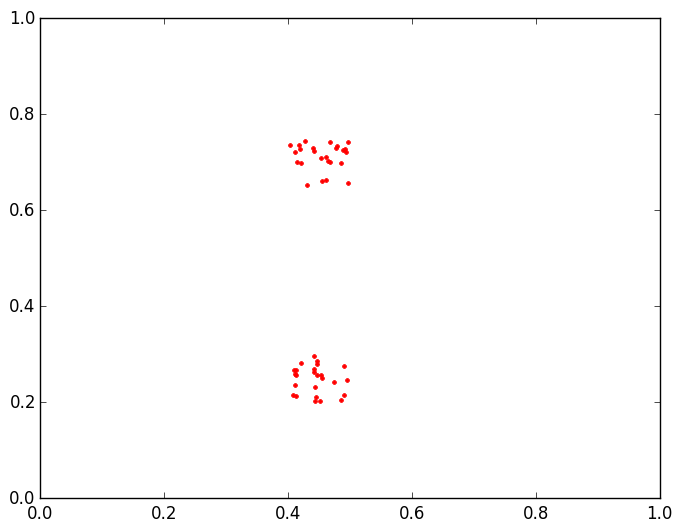

2x50 Array{Float64,2}:
 -2.0  2.0  -2.0  2.0  -2.0  2.0  -2.0  …  -2.0  2.0  -2.0  2.0  -2.0  2.0
  0.0  0.0   0.0  0.0   0.0  0.0   0.0      0.0  0.0   0.0  0.0   0.0  0.0

In [142]:
#initial states input here

position1=rand(2,25)/10
position1[1,:]=position1[1,:]+0.4
position1[2,:]=position1[2,:]+0.65
position2=rand(2,25)/10
position2[1,:]=position2[1,:]+0.4
position2[2,:]=position2[2,:]+0.2
position=[position1;position2]
position=reshape(position,2,50)
# position[:,26:end]=position[:,26:end]/2+0.5
plot(position[1,:],position[2,:],"r.")
xlim([0,1])
ylim([0,1])


velocity1=zeros(2,25)
velocity1[1,:]=-2.0*ones(1,25)
velocity2=zeros(2,25)
velocity2[1,:]=2.0*ones(1,25)


velocity=[velocity1;velocity2]
velocity=reshape(velocity,2,50)


In [150]:

N=50
Root=Node()
# position=rand(2,N)
Root.position=position
# velocity=zeros(2,N)

Root.velocity=velocity
Root.number_of_particles=N
Root.level=0
Root.index=1
s=1
l=floor(log(N/s)/log(4))

tree=[Root]
leaf=[]


leaf=balance_split!(Root,tree,l,leaf)
post_traversal(Root,tree)

all=compute_potential_FMM(tree,leaf,N)
position=all[1:2,:]
velocity=all[3:4,:]


# x=position[1,:]
# y=position[2,:]
# vx=velocity[1,:]
# vy=velocity[2,:]


#compute 10000 time steps

x11=zeros(10000,N)
y11=zeros(10000,N)
vx=zeros(10000,N)
vy=zeros(10000,N)

 tic();

for i=1:10000
    
Root=Node()
Root.position=position
Root.velocity=velocity
Root.number_of_particles=N
Root.level=0
Root.index=1   
    
leaf=[]


leaf=balance_split!(Root,tree,l,leaf)
post_traversal(Root,tree)

all=compute_potential_FMM(tree,leaf,N)

position=all[1:2,:]
velocity=all[3:4,:]

    x11[i,:]=position[1,:]
    y11[i,:]=position[2,:]
#     vx[i,:]=velocity[1,:]
#     vy[i,:]=velocity[2,:]
end

 t=toc();

LoadError: LoadError: DimensionMismatch("new dimensions (2,50) must be consistent with array size 0")
while loading In[150], in expression starting on line 44

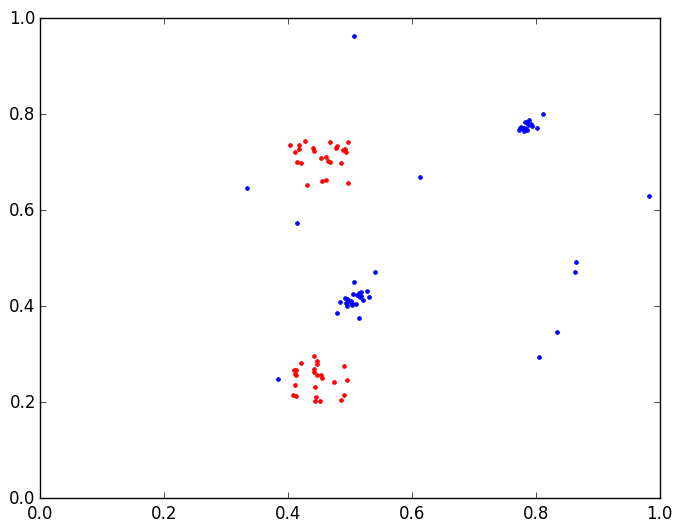

(0,1)

In [153]:
#show the initial and the final positions

plot(x11[1,:],y11[1,:],"r.");
plot(x11[28000,:],y11[28000,:],"b.");
xlim([0,1])
ylim([0,1])

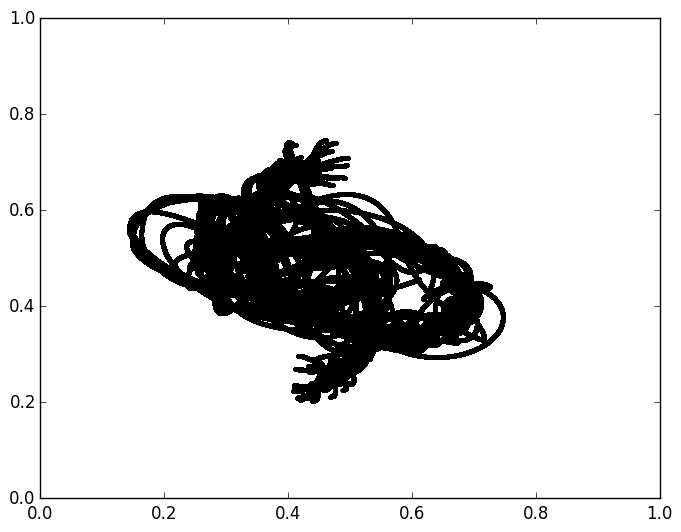

(0,1)

In [120]:
#show orbitals

for i=1:N
    plot(x[1:end-5,i],y[1:end-5,i],"k.")
end
xlim([0,1])
ylim([0,1])

In [40]:
#Barnes-Hut 

N=10000
Root=Node()
position=rand(2,N)
Root.position=position
Root.velocity=zeros(2,N)
Root.number_of_particles=N
Root.level=0
Root.index=1


tree=[Root]

s=8
l=floor(log(N/s)/log(4))


tic();
leaf=[]

leaf=balance_split!(Root,tree,l,leaf)
t_tree=toc();

phi_BH_array=zeros(1,N)

complex_position=position[1,:]+position[2,:]*1im;

tic();

for j=1:N
    z=complex_position[j]

    phi_BH_array[j]=compute_potential_BH(Root,tree,z,0);

end
t_BH=toc();


tic();
phi_dir_array=zeros(1,N);
for j=1:N 

phi_dir=0;
for i=1:N
    if i!=j
            phi_dir=phi_dir+log(norm(position[:,j]-position[:,i]));
    end
end
    phi_dir_array[j]=phi_dir;
end
t_dir=toc();

show("tree")
show(t_tree)
show("BH")
show(t_BH)
show("dir")
show(t_dir)


elapsed time: 0.310791285 seconds
elapsed time: 2.115877187 seconds
elapsed time: 78.704771169 seconds
"tree"0.310791285"BH"2.115877187"dir"78.704771169